In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

import re
import string

from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [3]:
# Download Required NLTK Data
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data=pd.read_csv('/content/drive/MyDrive/NLP (Filoger)/2- ML/Ex03/IMDB Dataset.csv')


In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [9]:
df_value_counts = pd.DataFrame(data.sentiment.value_counts())
df_value_counts

,count
sentiment,
positive,25000
negative,25000


In [10]:
df_value_counts['count']

,count
sentiment,
positive,25000
negative,25000


In [11]:
indexes = list(df_value_counts.index.values)

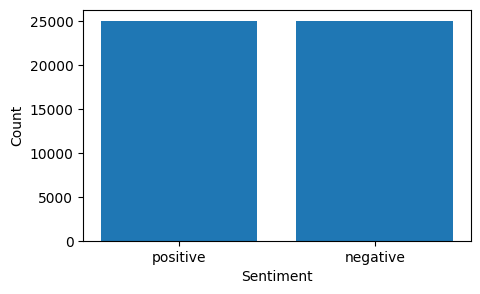

In [12]:
plt.figure(figsize=(5,3))
plt.bar(indexes, df_value_counts['count'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [13]:
data.replace({"positive":0, "negative":1}, inplace=True)

<ipython-input-13-d3dc32212e55>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"positive":0, "negative":1}, inplace=True)


In [14]:
# Text Preprocessing Function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    # Lowercase conversion
    text = text.lower()
    # Remove 's
    text = re.sub(r"'s", '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Expand contractions
    contractions = {"don't": "do not", "i'm": "i am", "it's": "it is"}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    # Remove URLs, @mentions, and hashtags and numbers
    text = re.sub(r'http\S+|www\S+|@\S+|#\S+|\d+', '', text)
    # Remove unnecessary spaces
    text = re.sub(r'\s\s+',' ',text)
    # Remove html tags
    text = re.sub(r'[^<].[>$]','',text)
    # Remove stopwords
    text = " ".join([word for word in str(text).split() if word not in stop_words])
    # Removing repeating characters
    text = re.sub(r'(\b.\b)\1+', r'\1', text)
    return text

# Apply Preprocessing
data['clean_text'] = data['review'].apply(preprocess_text)

In [15]:
print("\nPreprocessed Text Example:\n", data['clean_text'].head())
print()
print("Non-processed Text Example:\n", data["review"].head())


Preprocessed Text Example:
 0    one reviewers mentioned watching oz episode yo...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: clean_text, dtype: object

Non-processed Text Example:
 0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object


In [16]:
X_train, X_test, y_train, y_test=train_test_split(data['clean_text'], data['sentiment'], test_size=0.2, random_state=42)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=1, max_df=0.95, binary=False, ngram_range=(1, 3))

cv_train_reviews = cv.fit_transform(X_train)
cv_test_reviews = cv.transform(X_test)

print('BOW_cv_train:', cv_train_reviews.shape)
print('BOW_cv_test:', cv_test_reviews.shape)

vocab = cv.get_feature_names_out()
print('Vocabulary size:', len(vocab))

BOW_cv_train: (40000, 7224802)
BOW_cv_test: (10000, 7224802)
Vocabulary size: 7224802


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=1, max_df=0.95, use_idf=True, ngram_range=(1, 3))

tv_train_reviews = tv.fit_transform(X_train)

tv_test_reviews = tv.transform(X_test)
print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)
# Vocabulary size
vocab = tv.get_feature_names_out()
print('Vocabulary size:', len(vocab))

Tfidf_train: (40000, 7224802)
Tfidf_test: (10000, 7224802)
Vocabulary size: 7224802


In [19]:
logreg = LogisticRegression(max_iter=1000)
nb = MultinomialNB()

logreg.fit(cv_train_reviews, y_train)
nb.fit(cv_train_reviews, y_train)

logreg_preds = logreg.predict(cv_test_reviews)
nb_preds = nb.predict(cv_test_reviews)

print("Logistic Regression Accuracy: ", accuracy_score(y_test, logreg_preds))
print("Naive Bayes Accuracy: ", accuracy_score(y_test, nb_preds))

print("Logistic Regression Classification Report: ")
print(classification_report(y_test, logreg_preds))
print("Naive Bayes Classification Report: ")
print(classification_report(y_test, nb_preds))

Logistic Regression Accuracy:  0.8998
Naive Bayes Accuracy:  0.8893
Logistic Regression Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5039
           1       0.91      0.89      0.90      4961

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Naive Bayes Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5039
           1       0.88      0.90      0.89      4961

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [22]:
import seaborn as sns

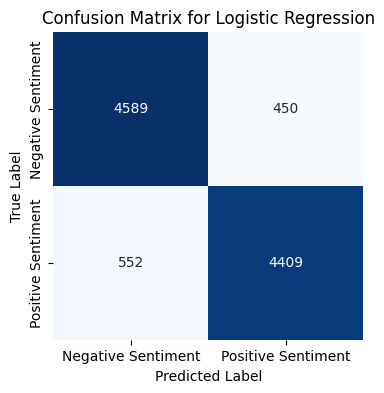

In [33]:
conf_matrix = confusion_matrix(y_test, logreg_preds)

plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative Sentiment", "Positive Sentiment"], yticklabels=["Negative Sentiment", "Positive Sentiment"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

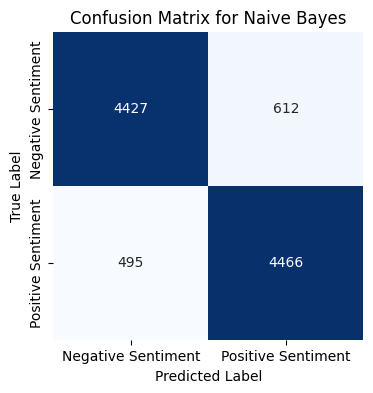

In [34]:
conf_matrix = confusion_matrix(y_test, nb_preds)

plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative Sentiment", "Positive Sentiment"], yticklabels=["Negative Sentiment", "Positive Sentiment"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

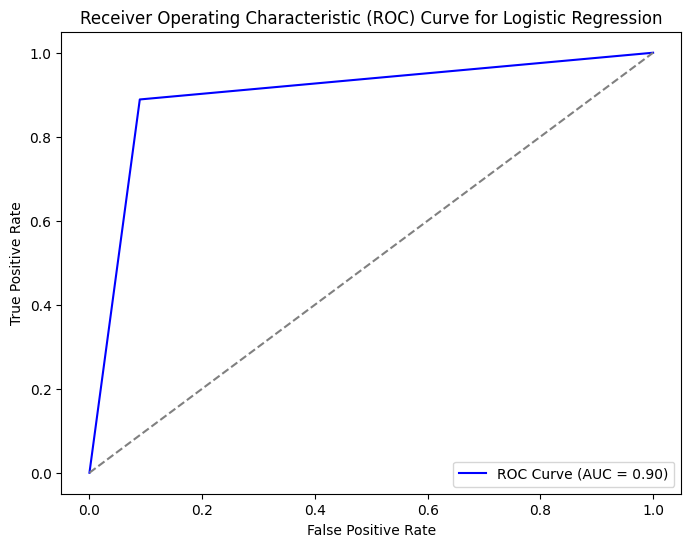

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, logreg_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.show()

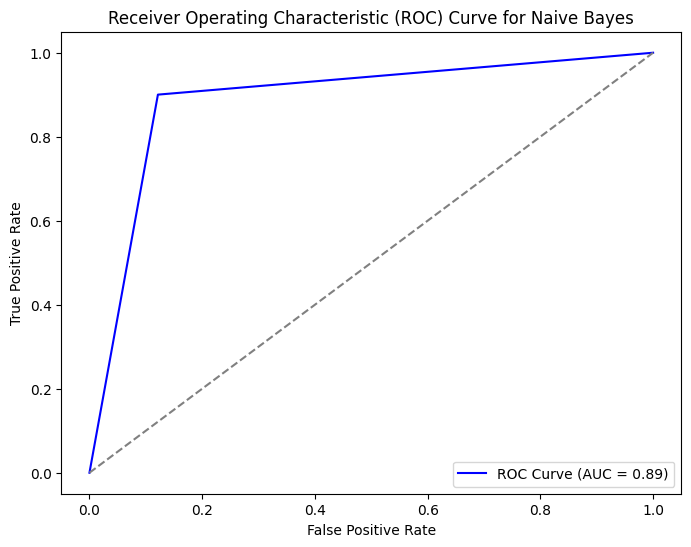

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, nb_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Naive Bayes")
plt.legend(loc="lower right")
plt.show()